In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import ROOT
import random

Welcome to JupyROOT 6.28/04


## Scintillazione

In [4]:
sipm = pd.read_csv('13360-3050pe_pde.csv', names=['lambd', 'pde'], sep='; ', decimal=',')
i_sipm_pde = interp1d(sipm.lambd, sipm.pde, bounds_error=False, fill_value=0)

/var/folders/7d/j3d39pm9439d4g_kq83cv2lw0000gn/T/ipykernel_3443/3957455931.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sipm = pd.read_csv('13360-3050pe_pde.csv', names=['lambd', 'pde'], sep='; ', decimal=',')


In [5]:
sr=np.concatenate([np.arange(0, 20), np.arange(1180,1228)])
#Efficienza
e_BGO = pd.read_table('BGO.csv', skiprows=sr, sep=';', decimal=',', names=['wl', 'e'])
e_PWO = pd.read_table('PWO_320_900nm.csv', skiprows=sr, sep=';', decimal=',', names=['wl', 'e'])

In [6]:
#Trasmittanza
t_BGO = pd.read_table('BGO.Sample.csv', skiprows=2,sep=',', names=['wl', 't'])
t_PWO = pd.read_table('PWO.Sample.csv', skiprows=2,sep=',', names=['wl', 't'])

Visualizziamo i dati relativi alla trasmissione e all'intensità di emissione, insieme a una funzione di efficienza di rivelazione fotoelettrica (PDE) su un fondo comune.

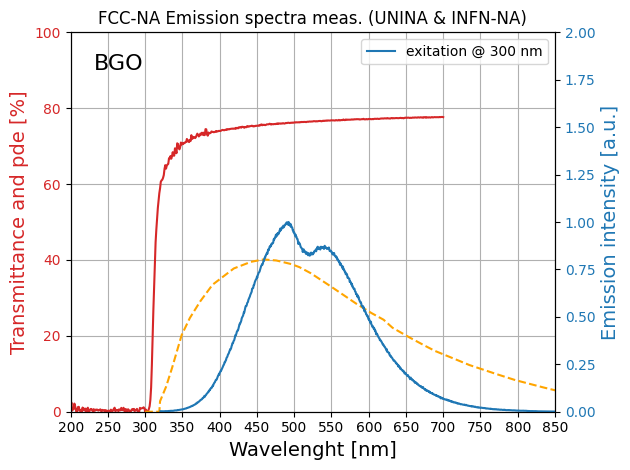

In [7]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Wavelenght [nm]', fontsize=14)
ax1.set_ylabel('Transmittance and pde [%]', color=color, fontsize=14)
ax1.plot(t_BGO.wl, t_BGO.t, color=color, label='transmittance')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Emission intensity [a.u.]', color=color, fontsize=14)  
ax2.plot(e_BGO.wl, e_BGO.e/e_BGO.e.max(), color=color, label='exitation @ 300 nm') #traccia l'intensità di emissione normalizzata in funzione della lunghezza d'onda 
x = np.arange(300, 900, 1)
ax1.plot(x, i_sipm_pde(x)/1, '--', label='S14460 pde', color='orange')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0, 2)
ax1.set_ylim(-0, 100)
plt.legend()

ax2.annotate(r'BGO', xycoords='axes fraction', xy=(0.1, 0.9), ha='center', fontsize=16)
plt.title('FCC-NA Emission spectra meas. (UNINA & INFN-NA)', size=12)
ax1.grid()
ax1.set_xticks(np.arange(200, 901, 50))
ax1.set_xlim(200, 850)
fig.tight_layout()  

plt.savefig('BGO.png', dpi=300, bbox_inches='tight')

plt.show()

## BGO
Creiamo un istogramma di valori distributi secondo l'intensità di emissione (Curva blue).

In [70]:
%jsroot
wl = e_BGO.wl
freq = e_BGO.e/e_BGO.e.max()
hist_BGO= ROOT.TH1F("hist_BGO", "Emission intensity", 100000 , 300, 850)

for i in range(len(wl)):
    hist_BGO.Fill(wl[i], freq[i])

canvas = ROOT.TCanvas("canvas", "Istogramma", 800, 600)
hist1=ROOT.TH1F("hist_BGO_prova", "Emission intensity", 100000 , 300, 850)
hist1.Add(hist_BGO)
#hist_BGO.Rebin(500)
hist1.Scale(11)
hist_BGO.SetLineColor(ROOT.kRed)
hist_BGO.SetFillColor(ROOT.kRed)
print(" n bins ",hist_BGO.GetNbinsX())
hist1.Draw("hist")
hist_BGO.Draw("hist")
canvas.Draw()
print(freq.max())

 n bins  100000
1.0


Warning in <TROOT::Append>: Replacing existing TH1: hist_BGO (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist_BGO_prova (Potential memory leak).


In [86]:
events = []

for _ in range(10000):
    value = hist_BGO.GetRandom()
    events.append(value)

In questo modo abbiamo entratto 10 mila eventi nell istogramma relativo all'intensità di emissione.
Per ogni lambda calcoliamo trasmittanza ed efficienza.

In [72]:
%jsroot
wl = t_BGO.wl
freq = t_BGO.t/t_BGO.t.max()
hist_Trasmittance= ROOT.TH1F("hist_BGO", "Trasmittance", 1000000 , 300, 850)

for i in range(len(wl)):
    hist_Trasmittance.Fill(wl[i], freq[i])

canvas = ROOT.TCanvas("canvas", "Istogramma", 800, 600)
hist_Trasmittance.Rebin(20000)
maxT= hist_Trasmittance.GetMaximum()
hist_Trasmittance.Scale(0.8/maxT)
hist_Trasmittance.Draw("hist")
canvas.Draw()

values_Trasmittance = []

for e in events:
    bi=hist_Trasmittance.FindBin(e)
    vtr=hist_Trasmittance.GetBinContent(bi)
    values_Trasmittance.append(vtr)

Warning in <TROOT::Append>: Replacing existing TH1: hist_BGO (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


In [77]:
%jsroot
#wl = sipm.lambd
wl = np.arange(300,900,1)
#freq = sipm.pde/sipm.pde.max()
freq = [i_sipm_pde(xi) for xi in wl] 
hist_pde= ROOT.TH1F("hist_BGO", "Pde", 1000000 , 279, 896)


for i in range(len(wl)):
    hist_pde.Fill(wl[i], freq[i])

canvas = ROOT.TCanvas("canvas", "Istogramma", 800, 600)
hist_pde.Rebin(1620)
maxp= hist_pde.GetMaximum()
hist_pde.Scale(0.4/maxp)
hist_pde.SetFillColor(ROOT.kBlue)
hist_pde.Draw("hist")
canvas.Draw()

values_pde = []

for e in events:
    bi=hist_pde.FindBin(e)
    vpde=hist_pde.GetBinContent(bi)
    values_pde.append(vpde)

Warning in <TROOT::Append>: Replacing existing TH1: hist_BGO (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TH1F::Rebin>: ngroup=1620 is not an exact divider of nbins=1000000.


In [78]:
eff_singolo_fotone_list = []

for t_value, pde_value in zip(values_Trasmittance,values_pde) :
    eff_singolo_fotone_value = t_value * pde_value
    eff_singolo_fotone_list.append(eff_singolo_fotone_value)
#    print("t value: ", t_value)
#    print("pde value: ", pde_value)

eff_media = sum(eff_singolo_fotone_list) / len(eff_singolo_fotone_list)
print("L'efficienza media associata al singolo fotone è:", eff_media)

efficienze_tot = 0

for elemento in eff_singolo_fotone_list:
    efficienze_tot += elemento

print("La somma di tutte le efficienze è:", efficienze_tot)

fotoni_attesi = 108276
fotoni_effettivi = fotoni_attesi * eff_media 
print("I fotoni attesi sono: ", fotoni_effettivi)
#print(eff_singolo_fotone_list)

L'efficienza media associata al singolo fotone è: 0.2626916589167322
La somma di tutte le efficienze è: 2626.916589167322
I fotoni attesi sono:  28443.202060868094


## PWO

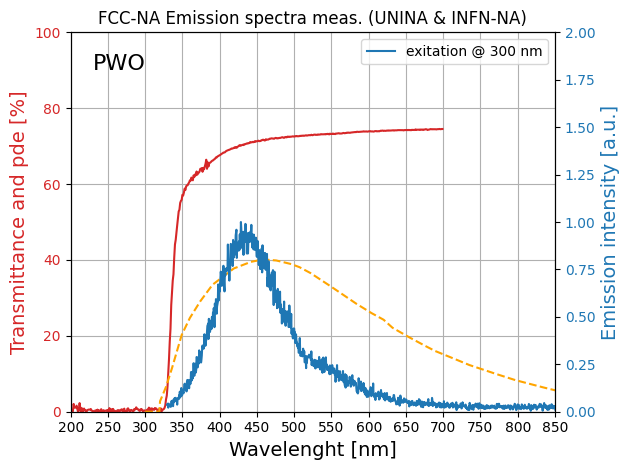

In [10]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Wavelenght [nm]', fontsize=14)
ax1.set_ylabel('Transmittance and pde [%]', color=color, fontsize=14)
ax1.plot((t_PWO.wl[:-1]+t_PWO.wl[1:])/2, (t_PWO.t[:-1]+t_PWO.t[1:])/2, color=color, label='transmittance')
ax1.tick_params(axis='y', labelcolor=color)

#plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Emission intensity [a.u.]', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(e_PWO.wl, e_PWO.e/e_PWO.e.max(), color=color, label='exitation @ 300 nm')
x = np.arange(300, 900, 1)
ax1.plot(x, i_sipm_pde(x), '--', label='S14460 pde', color='orange')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0, 2)
ax1.set_ylim(-0, 100)
plt.legend()

ax2.annotate(r'PWO', xycoords='axes fraction', xy=(0.1, 0.9), ha='center', fontsize=16)# fontweight='bold')#, style='italic')

plt.title('FCC-NA Emission spectra meas. (UNINA & INFN-NA)', size=12)
ax1.grid()
ax1.set_xticks(np.arange(200, 901, 50))
ax1.set_xlim(200, 850)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig('PWO.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
%jsroot
wl = e_PWO.wl
freq = e_PWO.e/e_PWO.e.max()
hist_PWO= ROOT.TH1F("hist_PWO", "Emission intensity", 100000 , 300, 850)

for i in range(len(wl)):
    hist_PWO.Fill(wl[i], freq[i])

canvas = ROOT.TCanvas("canvas", "Istogramma", 800, 600)
hist_PWO.Draw()
canvas.Draw()
print(freq.max())

1.0


In [14]:
events = []

for _ in range(10000):
    value = hist_PWO.GetRandom()
    events.append(value)

In [15]:
%jsroot
wl = t_PWO.wl
freq = t_PWO.t/t_PWO.t.max()
hist_Trasmittance= ROOT.TH1F("hist_PWO", "Trasmittance", 1000000 , 300, 850)

for i in range(len(wl)):
    hist_Trasmittance.Fill(wl[i], freq[i])

canvas = ROOT.TCanvas("canvas", "Istogramma", 800, 600)
hist_Trasmittance.Rebin(20000)
maxT= hist_Trasmittance.GetMaximum()
hist_Trasmittance.Scale(0.8/maxT)
hist_Trasmittance.Draw("hist")
canvas.Draw()

values_Trasmittance = []

for e in events:
    bi=hist_Trasmittance.FindBin(e)
    vtr=hist_Trasmittance.GetBinContent(bi)
    values_Trasmittance.append(vtr)

Warning in <TROOT::Append>: Replacing existing TH1: hist_PWO (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


In [16]:
%jsroot
wl = np.arange(300,900,1)
freq = [i_sipm_pde(xi) for xi in wl] 
hist_pde= ROOT.TH1F("hist_BGO", "Pde", 1000000 , 279, 896)


for i in range(len(wl)):
    hist_pde.Fill(wl[i], freq[i])

canvas = ROOT.TCanvas("canvas", "Istogramma", 800, 600)
hist_pde.Rebin(1620)
maxp= hist_pde.GetMaximum()
hist_pde.Scale(0.4/maxp)
hist_pde.SetFillColor(ROOT.kBlue)
hist_pde.Draw("hist")
canvas.Draw()

values_pde = []

for e in events:
    bi=hist_pde.FindBin(e)
    vpde=hist_pde.GetBinContent(bi)
    values_pde.append(vpde)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TH1F::Rebin>: ngroup=1620 is not an exact divider of nbins=1000000.


In [17]:
eff_singolo_fotone_list = []

for t_value, pde_value in zip(values_Trasmittance,values_pde) :
    eff_singolo_fotone_value = t_value * pde_value
    eff_singolo_fotone_list.append(eff_singolo_fotone_value)


eff_media = sum(eff_singolo_fotone_list) / len(eff_singolo_fotone_list)
print("L'efficienza media associata al singolo fotone è:", eff_media)

efficienze_tot = 0

for elemento in eff_singolo_fotone_list:
    efficienze_tot += elemento

print("La somma di tutte le efficienze è:", efficienze_tot)

fotoni_attesi = 230
fotoni_effettivi = fotoni_attesi * eff_media 
print("I fotoni attesi sono: ", fotoni_effettivi)


L'efficienza media associata al singolo fotone è: 0.2602290843671726
La somma di tutte le efficienze è: 2602.290843671726
I fotoni attesi sono:  59.852689404449706


## Cherenkov
Calcoliamo allo stesso modo l'efficienza per i fotoni Cherenkov.

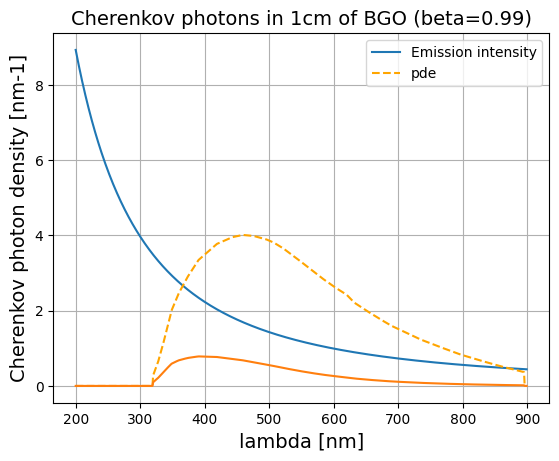

In [23]:
alpha = 1/137.035
dE_mip = 2 #MeV / (g/cm2)

bgo_density = 7.13 #g/cm3
bgo_sLY = 8000 #photons/MeV
bgo_dEdx = dE_mip * bgo_density #MeV/cm 
bgo_sphotons = bgo_dEdx*bgo_sLY #photons/cm
bgo_n = 2.15

z, beta = 1, 0.99

def d2Ndxdlamb(lambd, n, z, beta): #lambda espresso in nm. return light yield per cm per nm
    return 2*np.pi*(z**2)*alpha*(1/lambd**2)*(1-1/((n*beta)**2))*1E9*1E-2

def dNdx(lambd1, lambd2, n, z, beta): #lambda espresso in nm. return light yield per cm in un intervallo di lunghezze d'onda
    return 2*np.pi*(z**2)*alpha*(1/lambd1-1/lambd2)*(1-1/((n*beta)**2))*1E9*1E-2

x = np.arange(200, 900, 1)

plt.plot(x, d2Ndxdlamb(x, bgo_n, z, beta), label = 'Emission intensity')
plt.plot(x, i_sipm_pde(x)/10, '--', label='pde', color='orange')
plt.plot(x, d2Ndxdlamb(x, bgo_n, z, beta)*i_sipm_pde(x)/100)

plt.xlabel('lambda [nm]', size=14)
plt.ylabel('Cherenkov photon density [nm-1]', size=14)
plt.title(f'Cherenkov photons in 1cm of BGO (beta={beta})', size=14)
plt.legend()
plt.grid()
plt.show()

In [25]:
%jsroot
x = np.arange(200, 900, 1)
wl = x
freq = [ d2Ndxdlamb(xi, bgo_n, z, beta ) for xi in wl]

hist_ch= ROOT.TH1F("hist_ch", "Emission intensity Cherenkov", 100 , 200, 900)


for i in range(len(wl)):
    hist_ch.Fill(wl[i], freq[i])

c = ROOT.TCanvas("c")
#canvas = ROOT.TCanvas("canvas", 800, 600)
hist_ch.SetLineColor(ROOT.kBlue)
hist_ch.SetFillColor(ROOT.kBlue)
#print(" n bins ",hist_BGO.GetNbinsX())

hist_ch.Draw("hist_ch")
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: hist_ch (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [34]:
events = []

for _ in range(10000):
    value = hist_ch.GetRandom()
    events.append(value)



### BGO

In [27]:
%jsroot
wl = t_BGO.wl
freq = t_BGO.t/t_BGO.t.max()
hist_Trasmittance= ROOT.TH1F("hist_BGO", "Trasmittance", 1000000 , 300, 850)

for i in range(len(wl)):
    hist_Trasmittance.Fill(wl[i], freq[i])

canvas = ROOT.TCanvas("canvas", "Istogramma", 800, 600)
hist_Trasmittance.Rebin(20000)
maxT= hist_Trasmittance.GetMaximum()
hist_Trasmittance.Scale(0.8/maxT)
hist_Trasmittance.Draw("hist")
canvas.Draw()

values_Trasmittance = []

for e in events:
    bi=hist_Trasmittance.FindBin(e)
    vtr=hist_Trasmittance.GetBinContent(bi)
    values_Trasmittance.append(vtr)

Warning in <TROOT::Append>: Replacing existing TH1: hist_BGO (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


In [28]:
%jsroot

wl = np.arange(300,900,1)
freq = [i_sipm_pde(xi) for xi in wl] 
hist_pde= ROOT.TH1F("hist_BGO", "Pde", 1000000 , 279, 896)


for i in range(len(wl)):
    hist_pde.Fill(wl[i], freq[i])

canvas = ROOT.TCanvas("canvas", "Istogramma", 800, 600)
hist_pde.Rebin(1620)
maxp= hist_pde.GetMaximum()
hist_pde.Scale(0.52/maxp)
hist_pde.SetFillColor(ROOT.kBlue)
hist_pde.Draw("hist")
canvas.Draw()

values_pde = []

for e in events:
    bi=hist_pde.FindBin(e)
    vpde=hist_pde.GetBinContent(bi)
    values_pde.append(vpde)

Warning in <TROOT::Append>: Replacing existing TH1: hist_BGO (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TH1F::Rebin>: ngroup=1620 is not an exact divider of nbins=1000000.


In [32]:
eff_singolo_fotone_list = []

for t_value, pde_value in zip(values_Trasmittance,values_pde) :
    eff_singolo_fotone_value = t_value * pde_value
    eff_singolo_fotone_list.append(eff_singolo_fotone_value)

eff_media = sum(eff_singolo_fotone_list) / len(eff_singolo_fotone_list)
print("L'efficienza media associata al singolo fotone è:", eff_media)

efficienze_tot = 0

for elemento in eff_singolo_fotone_list:
    efficienze_tot += elemento

print("La somma di tutte le efficienze è:", efficienze_tot)

fotoni_attesi = 108276
fotoni_effettivi = fotoni_attesi * eff_media 
print("I fotoni attesi sono: ", fotoni_effettivi)

L'efficienza media associata al singolo fotone è: 0.12186152160207325
La somma di tutte le efficienze è: 1218.6152160207325
I fotoni attesi sono:  13194.678112986083


### PWO

In [34]:
%jsroot
wl = t_PWO.wl
freq = t_PWO.t/t_PWO.t.max()
hist_Trasmittance= ROOT.TH1F("hist_PWO", "Trasmittance", 1000000 , 300, 850)

for i in range(len(wl)):
    hist_Trasmittance.Fill(wl[i], freq[i])

canvas = ROOT.TCanvas("canvas", "Istogramma", 800, 600)
hist_Trasmittance.Rebin(20000)
maxT= hist_Trasmittance.GetMaximum()
hist_Trasmittance.Scale(0.8/maxT)
hist_Trasmittance.Draw("hist")
canvas.Draw()

values_Trasmittance = []

for e in events:
    bi=hist_Trasmittance.FindBin(e)
    vtr=hist_Trasmittance.GetBinContent(bi)
    values_Trasmittance.append(vtr)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


In [35]:
%jsroot
wl = np.arange(300,900,1)
freq = [i_sipm_pde(xi) for xi in wl] 
hist_pde= ROOT.TH1F("hist_BGO", "Pde", 1000000 , 279, 896)


for i in range(len(wl)):
    hist_pde.Fill(wl[i], freq[i])

canvas = ROOT.TCanvas("canvas", "Istogramma", 800, 600)
hist_pde.Rebin(1620)
maxp= hist_pde.GetMaximum()
hist_pde.Scale(0.52/maxp)
hist_pde.SetFillColor(ROOT.kBlue)
hist_pde.Draw("hist")
canvas.Draw()

values_pde = []

for e in events:
    bi=hist_pde.FindBin(e)
    vpde=hist_pde.GetBinContent(bi)
    values_pde.append(vpde)

Warning in <TROOT::Append>: Replacing existing TH1: hist_BGO (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TH1F::Rebin>: ngroup=1620 is not an exact divider of nbins=1000000.


In [36]:
eff_singolo_fotone_list = []

for t_value, pde_value in zip(values_Trasmittance,values_pde) :
    eff_singolo_fotone_value = t_value * pde_value
    eff_singolo_fotone_list.append(eff_singolo_fotone_value)

eff_media = sum(eff_singolo_fotone_list) / len(eff_singolo_fotone_list)
print("L'efficienza media associata al singolo fotone è:", eff_media)

efficienze_tot = 0

for elemento in eff_singolo_fotone_list:
    efficienze_tot += elemento

print("La somma di tutte le efficienze è:", efficienze_tot)

fotoni_attesi = 108276
fotoni_effettivi = fotoni_attesi * eff_media 
print("I fotoni attesi sono: ", fotoni_effettivi)

L'efficienza media associata al singolo fotone è: 0.11909526230375975
La somma di tutte le efficienze è: 1190.9526230375975
I fotoni attesi sono:  12895.15862120189


## Cherenvov e scintillazione

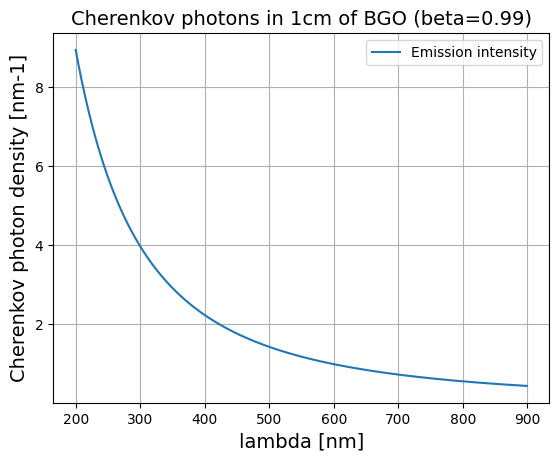

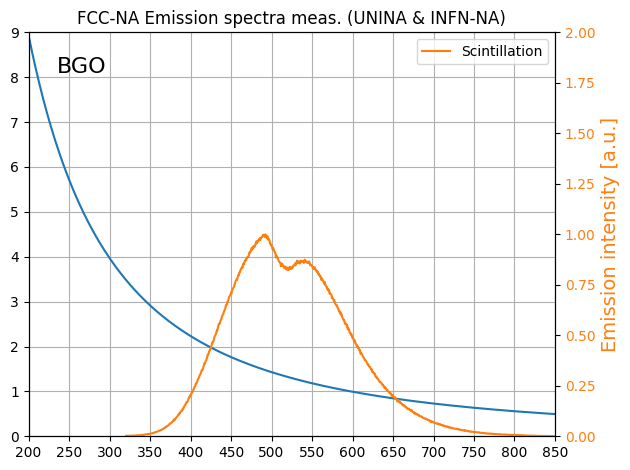

In [5]:
alpha = 1/137.035
dE_mip = 2 #MeV / (g/cm2)

bgo_density = 7.13 #g/cm3
bgo_sLY = 8000 #photons/MeV
bgo_dEdx = dE_mip * bgo_density #MeV/cm 
bgo_sphotons = bgo_dEdx*bgo_sLY #photons/cm
bgo_n = 2.15

z, beta = 1, 0.99

def d2Ndxdlamb(lambd, n, z, beta): #lambda espresso in nm. return light yield per cm per nm
    return 2*np.pi*(z**2)*alpha*(1/lambd**2)*(1-1/((n*beta)**2))*1E9*1E-2

def dNdx(lambd1, lambd2, n, z, beta): #lambda espresso in nm. return light yield per cm in un intervallo di lunghezze d'onda
    return 2*np.pi*(z**2)*alpha*(1/lambd1-1/lambd2)*(1-1/((n*beta)**2))*1E9*1E-2

x = np.arange(200, 900, 1)

plt.plot(x, d2Ndxdlamb(x, bgo_n, z, beta), label = 'Emission intensity')

plt.xlabel('lambda [nm]', size=14)
plt.ylabel('Cherenkov photon density [nm-1]', size=14)
plt.title(f'Cherenkov photons in 1cm of BGO (beta={beta})', size=14)
plt.legend()
plt.grid()
plt.show()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Emission intensity [a.u.]', color=color, fontsize=14)  
ax2.plot(e_BGO.wl, e_BGO.e/e_BGO.e.max(), color=color, label='Scintillation') #traccia l'intensità di emissione normalizzata in funzione della lunghezza d'onda 
x = np.arange(200, 900, 1)

ax1.plot(x, d2Ndxdlamb(x, bgo_n, z, beta), label = 'Cherenkov')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0, 2)
ax1.set_ylim(-0, 9)
plt.legend()

ax2.annotate(r'BGO', xycoords='axes fraction', xy=(0.1, 0.9), ha='center', fontsize=16)
plt.title('FCC-NA Emission spectra meas. (UNINA & INFN-NA)', size=12)
ax1.grid()
ax1.set_xticks(np.arange(200, 901, 50))
ax1.set_xlim(200, 850)
fig.tight_layout()  

Text(0.1, 0.9, 'BGO')

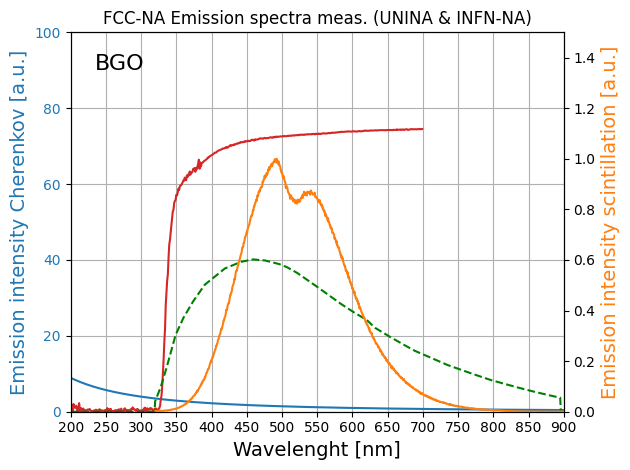

In [25]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Emission intensity scintillation [a.u.]', color=color, fontsize=14)  
ax2.plot(e_BGO.wl, e_BGO.e/e_BGO.e.max(), color=color, label='Scintillation')
x = np.arange(200, 900, 1)

ax1.plot(x, d2Ndxdlamb(x, bgo_n, z, beta), label='Cherenkov')
color = 'tab:blue'
ax1.set_ylabel('Emission intensity Cherenkov [a.u.]', color=color, fontsize=14)  
ax1.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0, 1.5)
ax1.set_ylim(-0, 100)

ax1.plot((t_PWO.wl[:-1] + t_PWO.wl[1:]) / 2, (t_PWO.t[:-1] + t_PWO.t[1:]) / 2, color='tab:red', label='Transmittance')

ax1.set_xlabel('Wavelenght [nm]', fontsize=14)

ax1.plot(x, i_sipm_pde(x)/1, '--', label='S14460 pde', color= 'green')


plt.title('FCC-NA Emission spectra meas. (UNINA & INFN-NA)', size=12)
ax1.grid()


ax1.set_xticks(np.arange(200, 901, 50))
ax1.set_xlim(200, 900)
fig.tight_layout()
ax2.annotate(r'BGO', xycoords='axes fraction', xy=(0.1, 0.9), ha='center', fontsize=16)

In [26]:
def step_function(x):
    if x < 400:
        return 0.99
    else:
        return 0.0001

Text(0.1, 0.9, 'PWO')

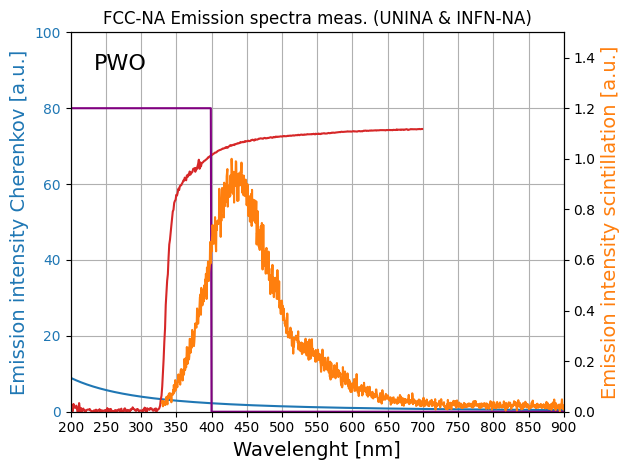

In [30]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Emission intensity scintillation [a.u.]', color=color, fontsize=14)  
ax2.plot(e_PWO.wl, e_PWO.e/e_PWO.e.max(), color=color, label='Scintillation')
x = np.arange(200, 900, 1)

ax1.plot(x, d2Ndxdlamb(x, bgo_n, z, beta), label='Cherenkov')
color = 'tab:blue'
ax1.set_ylabel('Emission intensity Cherenkov [a.u.]', color=color, fontsize=14)  
ax1.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0, 1.5)
ax1.set_ylim(-0, 100)

ax1.plot((t_PWO.wl[:-1] + t_PWO.wl[1:]) / 2, (t_PWO.t[:-1] + t_PWO.t[1:]) / 2, color='tab:red', label='Transmittance')
ax1.set_xlabel('Wavelenght [nm]', fontsize=14)

def custom_function(x):
    return np.where(x < 400, 80, 0.0001)

# Plot the custom function on the same graph
ax1.plot(x, custom_function(x), label='Custom Function', color='purple')



#plt.legend()
plt.title('FCC-NA Emission spectra meas. (UNINA & INFN-NA)', size=12)
ax1.grid()
ax1.set_xticks(np.arange(200, 901, 50))
ax1.set_xlim(200, 900)
fig.tight_layout()
ax2.annotate(r'PWO', xycoords='axes fraction', xy=(0.1, 0.9), ha='center', fontsize=16)

Ora vogliamo trovare il numero di fotoni Cherenkov atteso. Iniziamo a calcolare la ly del Cherenkov:

In [111]:
bgo_n = 2.15
z, beta = 1, 0.99
ly = dNdx(200, 900, bgo_n, z, beta)
print("la light yield del Cherenkov (BGO) è: ", ly, "/cm")

la light yield del Cherenkov (BGO) è:  1389.5184344285883 /cm


In [112]:
pwo_n = 2.16
z, beta = 1, 0.99
ly = dNdx(200, 900, pwo_n, z, beta)
print("la light yield del Cherenkov (PWO) è: ", ly, "/cm")

la light yield del Cherenkov (PWO) è:  1393.154204061596 /cm


Troviamo quindi il numero di Cherenkov atteso con la stessa simulazione usata per la luce di scintillazione.

## BGO: Cherenkov attesi
Calcolata mettendoci la ly del Cherenkov e l'efficienza del Cherenkov

In [9]:
%run ./Classe_2verticali_Efficienze.ipynb

I primi due valori più frequenti sono: [0.0, 10.137838954631174]


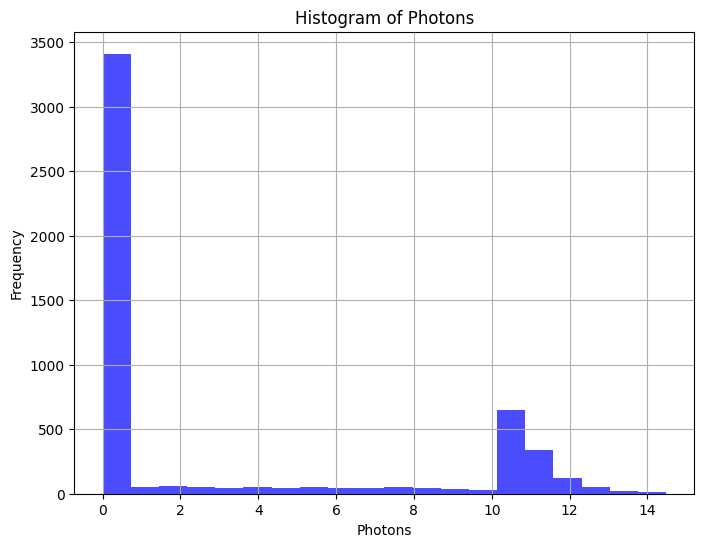

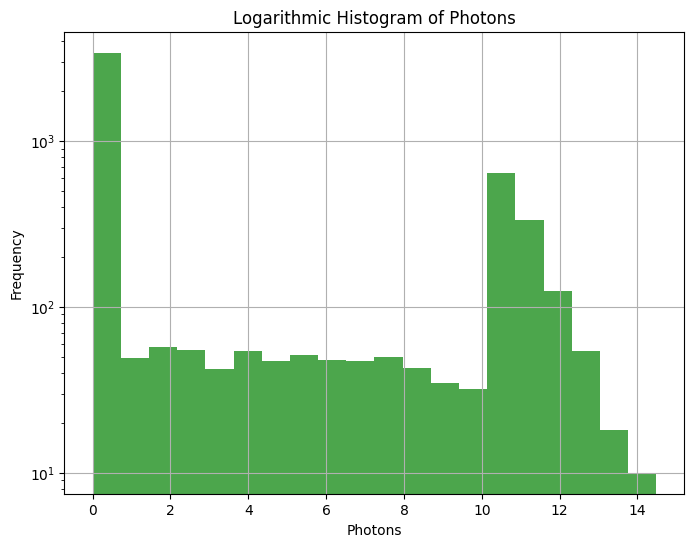

('Numero totale dei raggi',
 195840,
 'Numero di intersezioni rivelatori di trigger: ',
 52553,
 'Numero di intersezioni rivelatori di misura: ',
 19077,
 'Percentuale trigger/tot',
 26.83466094771242,
 'Percentuale measure/tot',
 9.741115196078432,
 'Accettanza geometrica',
 36.300496641485736,
 ' % Numero 1: ',
 59.87314567279971,
 ' % Numero 2: ',
 13.576558159039681,
 ' % Numero 3: ',
 13.676154531634953,
 ' % Numero 4: ',
 6.379409760444514,
 ' % Numero 5: ',
 6.494731876081144,
 'Energia rilasciata per muone',
 array([0., 0., 0., ..., 0., 0., 0.]),
 'MeV',
 'Lunghezza percorsa',
 array([0., 0., 0., ..., 0., 0., 0.]),
 'Fotoni attesi per muone',
 array([0., 0., 0., ..., 0., 0., 0.]),
 'Primi 10 dati',
 5     11.486235
 9     12.637318
 22     3.196949
 35    11.723581
 37    11.901920
 44    10.501889
 65    10.270861
 68    10.191263
 73    11.871452
 83    11.226405
 Name: photons, dtype: float64)

In [114]:
a_t1 = 0.051 #m
b_t1 = 0.051
a_t2 = 0.052
b_t2 = 0.048
h_t = 0.05
a_m = 0.05
b_m = 0.012
h_m = 0.012
detector_height = 0.001
total_time_hours = 48
density = 7130 #kg/m^3
muon_energy = 0.15 #MeV m^2 / kg
light_yield = 1389/(density/1000) #ph/MeV
detection_eff = 0.13
geometric_eff = 0.0625 * 0.5

rivelatori = Rivelatori(a_t1, b_t1, a_t2, b_t2, h_t, a_m, b_m, h_m, detector_height, total_time_hours, density, muon_energy, light_yield, detection_eff, geometric_eff)


released_energy, photons, d_m, muon_df = rivelatori.count_photons()
released_energy, photons, d_m, muon_df  = rivelatori.run(total_time_hours, get_dataframe=True, plot_graphs=True, plot_log_histogram=True)


rivelatori.plot_rays(graph_rays = False)
rivelatori.plot_trigger(graph_trigger = False)
rivelatori.plot_measure(graph_measure = False)

In [ ]:
a_t1 = 0.051 #m
b_t1 = 0.051
a_t2 = 0.052
b_t2 = 0.048
h_t = 0.054 
a_m = 0.05
b_m = 0.012
h_m = 0.012
detector_height = 0.001
total_time_hours = 48
density = 8280 #kg/m^3
muon_energy = 0.15 #MeV m^2 / kg
light_yield = 190 #ph/MeV #Per il BGO era 8200 ph/MeV
detection_eff = 0.11
geometric_eff = 0.0625 * 0.5


rivelatori = Rivelatori(a_t1, b_t1,a_t2, b_t2, h_t, a_m, b_m, h_m, detector_height, total_time_hours, density, muon_energy, light_yield, detection_eff, geometric_eff)

released_energy, photons, d_m, muon_df  = rivelatori.run(total_time_hours, get_dataframe=True, plot_graphs=True, plot_log_histogram=True)
released_energy, photons, d_m, muon_df = rivelatori.count_photons()

rivelatori.plot_rays(graph_rays = False)
rivelatori.plot_trigger(graph_trigger = False)
rivelatori.plot_measure(graph_measure = True)

## PWO: Cherenkov attesi

I primi due valori più frequenti sono: [0.0, 8.41860480833468]


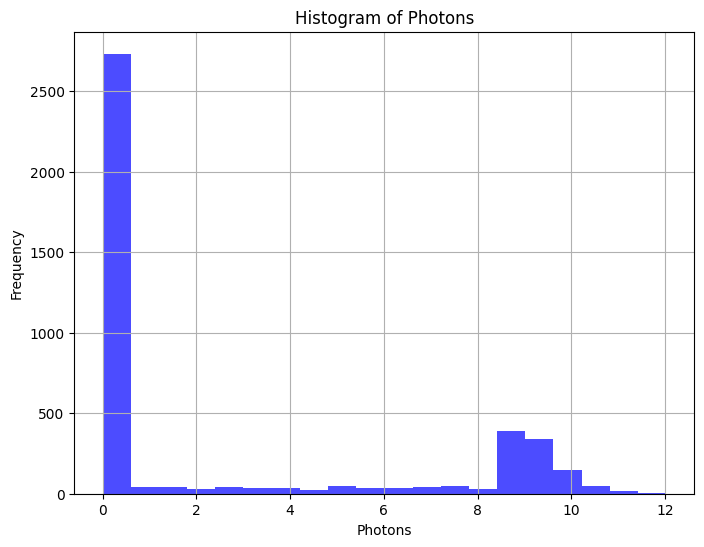

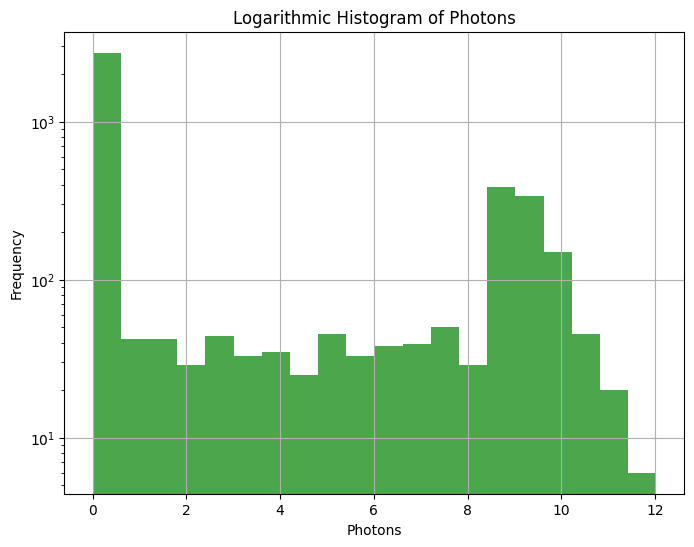

('Numero totale dei raggi',
 195840,
 'Numero di intersezioni rivelatori di trigger: ',
 48242,
 'Numero di intersezioni rivelatori di misura: ',
 17220,
 'Percentuale trigger/tot',
 24.633374183006538,
 'Percentuale measure/tot',
 8.792892156862745,
 'Accettanza geometrica',
 35.695037519174164,
 ' % Numero 1: ',
 61.94541231126597,
 ' % Numero 2: ',
 12.89198606271777,
 ' % Numero 3: ',
 13.182346109175377,
 ' % Numero 4: ',
 6.2369337979094075,
 ' % Numero 5: ',
 5.743321718931475,
 'Energia rilasciata per muone',
 array([ 0.       ,  0.       ,  0.       , ...,  0.       , 15.0482918,
         0.       ]),
 'MeV',
 'Lunghezza percorsa',
 array([0.        , 0.        , 0.        , ..., 0.        , 0.01211618,
        0.        ]),
 'Fotoni attesi per muone',
 array([0.        , 0.        , 0.        , ..., 0.        , 8.70263343,
        0.        ]),
 'Primi 10 dati',
 13     9.541286
 16     8.841047
 97     9.990499
 107    4.066849
 113    8.760632
 114    9.847799
 168    3.297

In [115]:
a_t1 = 0.051 #m
b_t1 = 0.051
a_t2 = 0.052
b_t2 = 0.048
h_t = 0.054 
a_m = 0.05
b_m = 0.012
h_m = 0.012
detector_height = 0.001
total_time_hours = 48
density = 8280 #kg/m^3
muon_energy = 0.15 #MeV m^2 / kg
light_yield = 1393/(density/1000) #ph/MeV #Per il BGO era 8200 ph/MeV
detection_eff = 0.11
geometric_eff = 0.0625 * 0.5


rivelatori = Rivelatori(a_t1, b_t1,a_t2, b_t2, h_t, a_m, b_m, h_m, detector_height, total_time_hours, density, muon_energy, light_yield, detection_eff, geometric_eff)

released_energy, photons, d_m, muon_df  = rivelatori.run(total_time_hours, get_dataframe=True, plot_graphs=True, plot_log_histogram=True)
released_energy, photons, d_m, muon_df = rivelatori.count_photons()

rivelatori.plot_rays(graph_rays = False)
rivelatori.plot_trigger(graph_trigger = False)
rivelatori.plot_measure(graph_measure = False)

## BGO : Cherenkov attesi con un filtro

I primi due valori più frequenti sono: [0.0, 2.360963502018302]


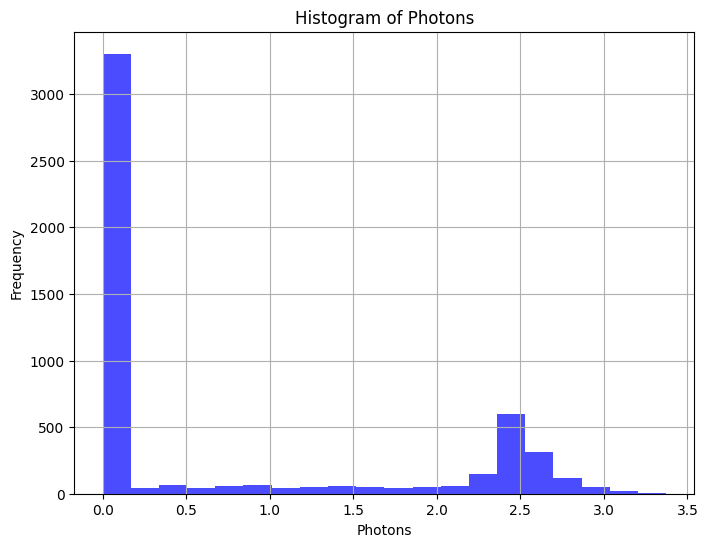

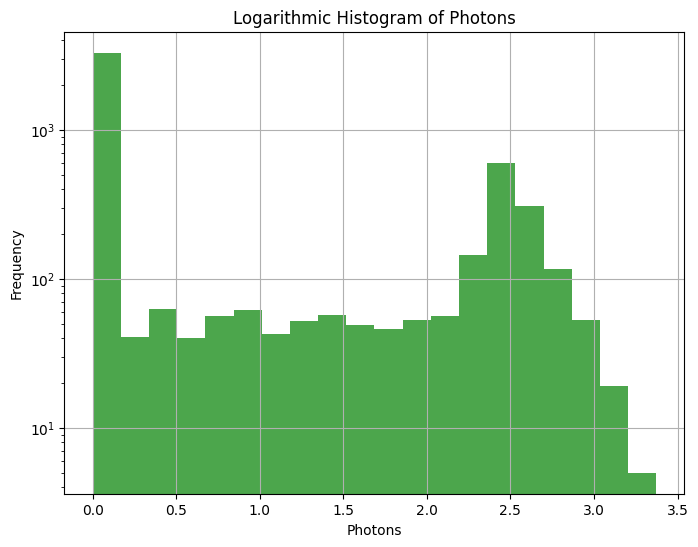

('Numero totale dei raggi',
 195840,
 'Numero di intersezioni rivelatori di trigger: ',
 52771,
 'Numero di intersezioni rivelatori di misura: ',
 19327,
 'Percentuale trigger/tot',
 26.94597630718954,
 'Percentuale measure/tot',
 9.868770424836601,
 'Accettanza geometrica',
 36.62428227625021,
 ' % Numero 1: ',
 59.321156930718686,
 ' % Numero 2: ',
 13.61308014694469,
 ' % Numero 3: ',
 14.058053500284576,
 ' % Numero 4: ',
 6.6849485176178405,
 ' % Numero 5: ',
 6.322760904434212,
 'Energia rilasciata per muone',
 array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        13.01357949, 13.35401024]),
 'MeV',
 'Lunghezza percorsa',
 array([0.        , 0.        , 0.        , ..., 0.        , 0.01216791,
        0.01248622]),
 'Fotoni attesi per muone',
 array([0.        , 0.        , 0.        , ..., 0.        , 2.376735  ,
        2.43890957]),
 'Primi 10 dati',
 4     0.426101
 6     2.669412
 8     2.392269
 15    0.984431
 19    2.495127
 20    1.690919
 28    1.12867

In [41]:
a_t1 = 0.051 #m
b_t1 = 0.051
a_t2 = 0.052
b_t2 = 0.048
h_t = 0.05
a_m = 0.05
b_m = 0.012
h_m = 0.012
detector_height = 0.001
total_time_hours = 48
density = 7130 #kg/m^3
muon_energy = 0.15 #MeV m^2 / kg
light_yield = 1389/(density/1000) #ph/MeV
detection_eff = 0.03
geometric_eff = 0.0625 * 0.5

rivelatori = Rivelatori(a_t1, b_t1, a_t2, b_t2, h_t, a_m, b_m, h_m, detector_height, total_time_hours, density, muon_energy, light_yield, detection_eff, geometric_eff)


released_energy, photons, d_m, muon_df = rivelatori.count_photons()
released_energy, photons, d_m, muon_df  = rivelatori.run(total_time_hours, get_dataframe=True, plot_graphs=True, plot_log_histogram=True)


rivelatori.plot_rays(graph_rays = False)
rivelatori.plot_trigger(graph_trigger = False)
rivelatori.plot_measure(graph_measure = False)

## PWO: Cherenkov attesi con un filtro

I primi due valori più frequenti sono: [0.0, 2.4101609879579198]


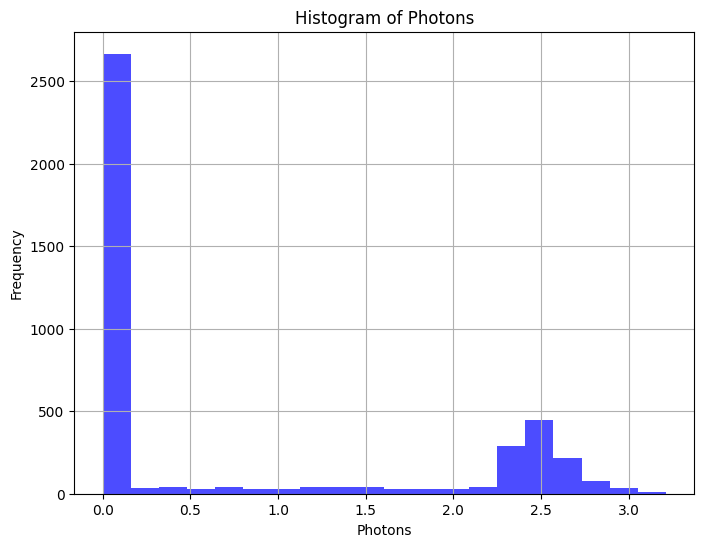

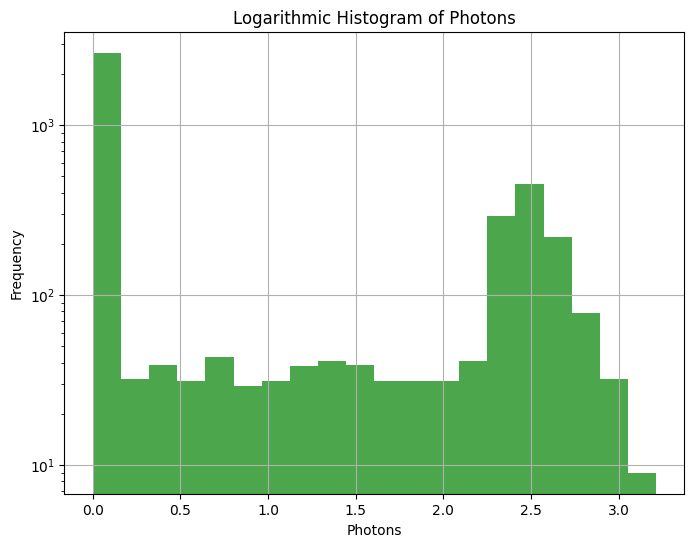

('Numero totale dei raggi',
 195840,
 'Numero di intersezioni rivelatori di trigger: ',
 47883,
 'Numero di intersezioni rivelatori di misura: ',
 16967,
 'Percentuale trigger/tot',
 24.450061274509803,
 'Percentuale measure/tot',
 8.663705065359476,
 'Accettanza geometrica',
 35.43428774304033,
 ' % Numero 1: ',
 61.36618141097424,
 ' % Numero 2: ',
 12.97813402487181,
 ' % Numero 3: ',
 13.490894088524783,
 ' % Numero 4: ',
 6.070607650144398,
 ' % Numero 5: ',
 6.094182825484765,
 'Energia rilasciata per muone',
 array([ 0.        , 15.94774089,  0.        , ...,  0.        ,
         0.        ,  0.        ]),
 'MeV',
 'Lunghezza percorsa',
 array([0.        , 0.01284037, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 'Fotoni attesi per muone',
 array([0.        , 2.51530832, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 'Primi 10 dati',
 1      2.515308
 3      2.351163
 7      0.758108
 22     2.543144
 28     2.405569
 73     1.114287
 83     2

In [40]:
a_t1 = 0.051 #m
b_t1 = 0.051
a_t2 = 0.052
b_t2 = 0.048
h_t = 0.054 
a_m = 0.05
b_m = 0.012
h_m = 0.012
detector_height = 0.001
total_time_hours = 48
density = 8280 #kg/m^3
muon_energy = 0.15 #MeV m^2 / kg
light_yield = 1393/(density/1000) #ph/MeV #Per il BGO era 8200 ph/MeV
detection_eff = 0.03
geometric_eff = 0.0625 * 0.5


rivelatori = Rivelatori(a_t1, b_t1,a_t2, b_t2, h_t, a_m, b_m, h_m, detector_height, total_time_hours, density, muon_energy, light_yield, detection_eff, geometric_eff)

released_energy, photons, d_m, muon_df  = rivelatori.run(total_time_hours, get_dataframe=True, plot_graphs=True, plot_log_histogram=True)
released_energy, photons, d_m, muon_df = rivelatori.count_photons()

rivelatori.plot_rays(graph_rays = False)
rivelatori.plot_trigger(graph_trigger = False)
rivelatori.plot_measure(graph_measure = False)

## Altro filtro

I primi due valori più frequenti sono: [0.0, 1.5571363007747785]


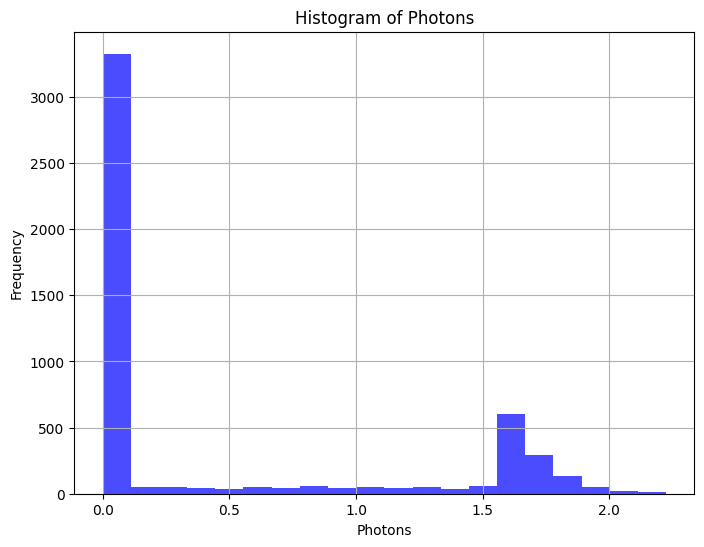

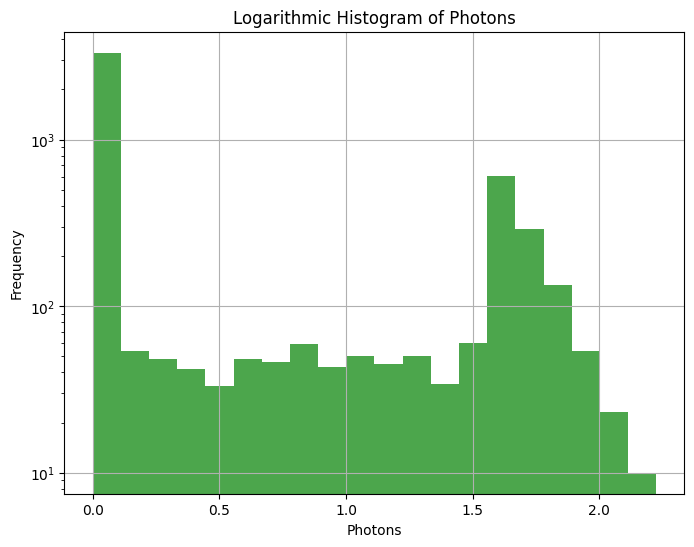

('Numero totale dei raggi',
 195840,
 'Numero di intersezioni rivelatori di trigger: ',
 52625,
 'Numero di intersezioni rivelatori di misura: ',
 19249,
 'Percentuale trigger/tot',
 26.87142565359477,
 'Percentuale measure/tot',
 9.828941993464053,
 'Accettanza geometrica',
 36.57767220902613,
 ' % Numero 1: ',
 59.53036521377734,
 ' % Numero 2: ',
 13.818899683100422,
 ' % Numero 3: ',
 13.663047431035377,
 ' % Numero 4: ',
 6.525014286456439,
 ' % Numero 5: ',
 6.462673385630422,
 'Energia rilasciata per muone',
 array([13.0348347,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]),
 'MeV',
 'Lunghezza percorsa',
 array([0.01218778, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 'Fotoni attesi per muone',
 array([1.58707796, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 'Primi 10 dati',
 0     1.587078
 12    1.588828
 15    1.120763
 42    1.737609
 64    0.645609
 73    1.709979
 74    0.953831
 75  

In [42]:
a_t1 = 0.051 #m
b_t1 = 0.051
a_t2 = 0.052
b_t2 = 0.048
h_t = 0.05
a_m = 0.05
b_m = 0.012
h_m = 0.012
detector_height = 0.001
total_time_hours = 48
density = 7130 #kg/m^3
muon_energy = 0.15 #MeV m^2 / kg
light_yield = 1389/(density/1000) #ph/MeV
detection_eff = 0.02
geometric_eff = 0.0625 * 0.5

rivelatori = Rivelatori(a_t1, b_t1, a_t2, b_t2, h_t, a_m, b_m, h_m, detector_height, total_time_hours, density, muon_energy, light_yield, detection_eff, geometric_eff)


released_energy, photons, d_m, muon_df = rivelatori.count_photons()
released_energy, photons, d_m, muon_df  = rivelatori.run(total_time_hours, get_dataframe=True, plot_graphs=True, plot_log_histogram=True)


rivelatori.plot_rays(graph_rays = False)
rivelatori.plot_trigger(graph_trigger = False)
rivelatori.plot_measure(graph_measure = False)

I primi due valori più frequenti sono: [0.0, 1.1640955809915177]


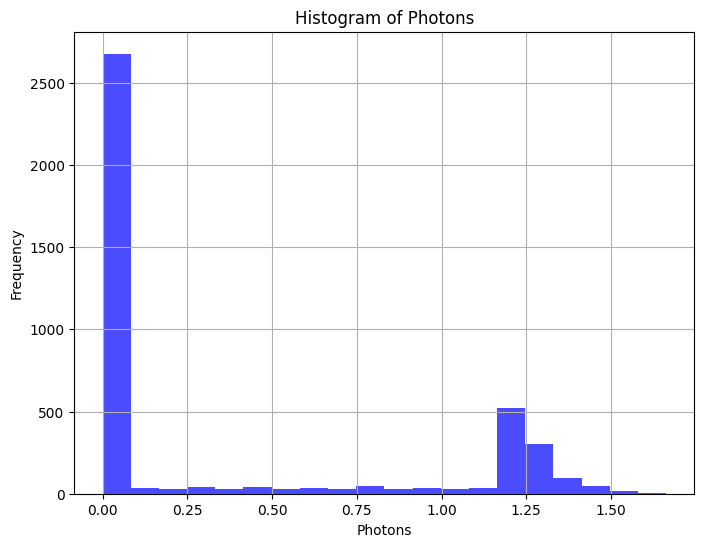

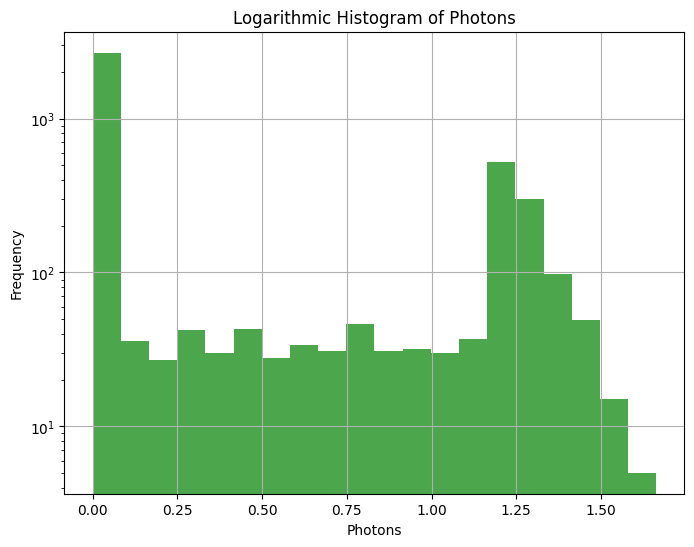

('Numero totale dei raggi',
 195840,
 'Numero di intersezioni rivelatori di trigger: ',
 48115,
 'Numero di intersezioni rivelatori di misura: ',
 16987,
 'Percentuale trigger/tot',
 24.568525326797385,
 'Percentuale measure/tot',
 8.67391748366013,
 'Accettanza geometrica',
 35.304998441234545,
 ' % Numero 1: ',
 61.94737151939719,
 ' % Numero 2: ',
 12.98640136575028,
 ' % Numero 3: ',
 12.956967092482486,
 ' % Numero 4: ',
 6.145876258315182,
 ' % Numero 5: ',
 5.963383764054866,
 'Energia rilasciata per muone',
 array([0., 0., 0., ..., 0., 0., 0.]),
 'MeV',
 'Lunghezza percorsa',
 array([0., 0., 0., ..., 0., 0., 0.]),
 'Fotoni attesi per muone',
 array([0., 0., 0., ..., 0., 0., 0.]),
 'Primi 10 dati',
 9      1.224084
 25     1.223821
 37     1.292026
 40     1.202745
 50     0.991383
 51     1.274018
 62     0.053245
 90     1.172414
 103    0.605477
 106    1.291589
 Name: photons, dtype: float64)

In [43]:
a_t1 = 0.051 #m
b_t1 = 0.051
a_t2 = 0.052
b_t2 = 0.048
h_t = 0.054 
a_m = 0.05
b_m = 0.012
h_m = 0.012
detector_height = 0.001
total_time_hours = 48
density = 8280 #kg/m^3
muon_energy = 0.15 #MeV m^2 / kg
light_yield = 1393/(density/1000) #ph/MeV #Per il BGO era 8200 ph/MeV
detection_eff = 0.015
geometric_eff = 0.0625 * 0.5


rivelatori = Rivelatori(a_t1, b_t1,a_t2, b_t2, h_t, a_m, b_m, h_m, detector_height, total_time_hours, density, muon_energy, light_yield, detection_eff, geometric_eff)

released_energy, photons, d_m, muon_df  = rivelatori.run(total_time_hours, get_dataframe=True, plot_graphs=True, plot_log_histogram=True)
released_energy, photons, d_m, muon_df = rivelatori.count_photons()

rivelatori.plot_rays(graph_rays = False)
rivelatori.plot_trigger(graph_trigger = False)
rivelatori.plot_measure(graph_measure = False)